<a href="https://colab.research.google.com/github/sudotouchwoman/math-misc/blob/main/notebooks/weather-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to ML. Homework 2 by Teterin Nikita, ML-11 Fall 2021**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib notebook

np.random.seed(10)

## **1. Logistic regression implementation 📈**

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

Conditional probability formulae for logit

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [ ]:
def probability(theta, X):
  return 1. / (1. + np.exp(- X @ theta))

prob = probability(theta, X)

assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Binary class label predictor: for given $X$, probability threshold and $\theta$ produces collection of class labels. In this implementation the labels are $y \in \{0, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    labels = np.where(prob > threshold, 1, 0)
    # as required, the binary labels are 0 and 1
    # other ones can be used, e.g. -1 and 1
    return labels

y_pred = binary_class_prediction(theta, X)

assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

**Logit quality functional**

Write sample likelihood for class labels $y \in \{+1, -1\}$:

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Apply log to and turn *maximization problem* into *minimization problem*:

***note**: $[condition]$ evaluates to 1 if the condition in the brackets is **true** and to 0 otherwise (bool to int cast in math)

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Insert $a(x, \theta)$ defined earlier into $Q(a, X^\ell)$:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$

Let's get our hands dirty with some math and matrix operations!
    

In [ ]:
def logloss(theta, X, y):
    y_ones = np.where(y != 1, -1, 1)
    inverse_prob = 1 + np.exp( -y_ones * (X @ theta) )
    loss = np.sum(np.log(inverse_prob)) / len(y)
    return loss

In [ ]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

Gradient for  $Q(a, X^\ell)$ with respect to $\theta_j$ is given by:

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j} =  \frac{\partial \frac{1}{n}\sum_{i = 1}^{n} \log \left( 1 + \exp(- y_i \langle \theta, x_i \rangle) \right)} {\partial \theta_j} =\frac{1}{n}\sum_{i = 1}^{n} \frac {1}{ 1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

The function below computes gradient for given $\theta$, $X$ and $y$

In [ ]:
def gradient(theta, X, y):
    y_ones = np.where( y != 1, -1, 1)
    exp = np.exp(- y_ones * (X @ theta))

    gradient = np.sum((1 / (1 + exp) ) * exp * (- y_ones * X.T), axis=1) / len(y_ones)
    return gradient 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

In [ ]:
gradient(theta, X, y)

array([0.03681632, 0.07425094, 0.14471163])

In [ ]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

### **Take a look at binary classification results of our self-written logit**

In [ ]:
X, y = make_classification(n_samples=2000)

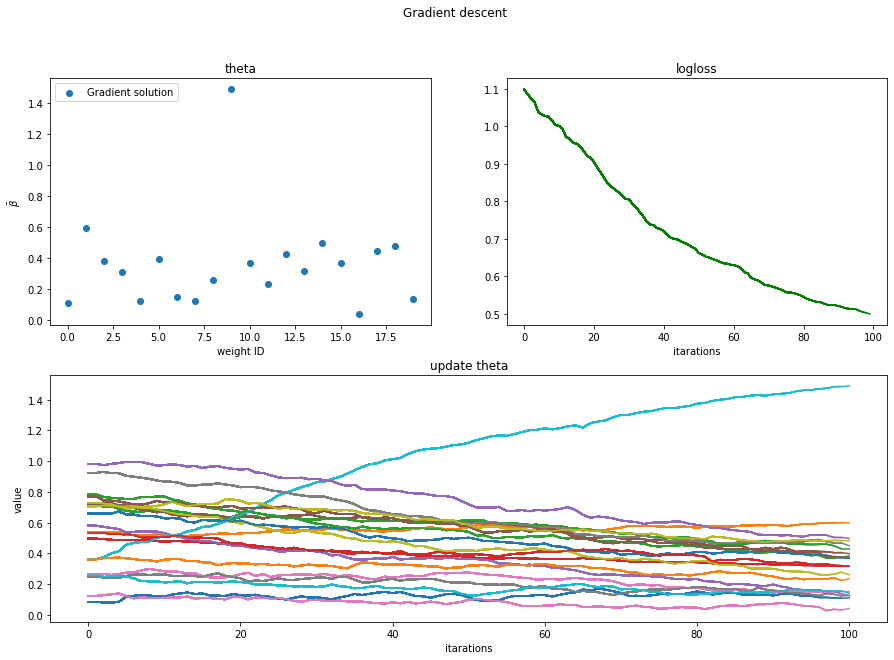

In [ ]:
optimal_theta = fit(X, y, plot=True)

In [ ]:
from sklearn.metrics import classification_report
y_pred = binary_class_prediction(optimal_theta, X)
print(f'Error summary: { (y_pred != y).sum() }/{y.shape[0]} ({( ((y_pred != y).sum()/y.shape[0])*100 ):.4f}%)')
print(f'Predicted {(np.mean(y_pred == y)*100):.4f}% correctly')
print(classification_report(y_pred, y, target_names=['0', '1']))

Error summary: 458/2000 (22.9000%)
Predicted 77.1000% correctly
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1089
           1       0.73      0.80      0.76       911

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



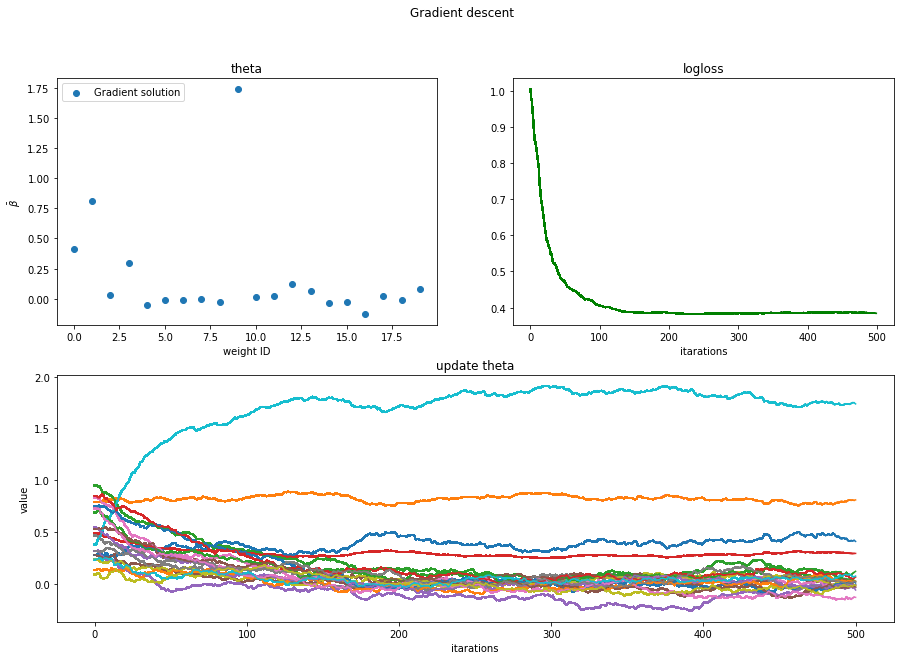

In [ ]:
optimal_theta = fit(X, y, batch_size=15, h=1e-1, iters=500)

Remarkably, with doubled default lr (1e-1) the accuracy increased ~~from about 84% up to 90.75%~~ from about 86.6% up to 90.65%

**Upd:** actually, the accuracy value changes among reruns `make_classification()` creates *random* samples and weights are initialized *randomly* aswell.

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X)
print(f'Error summary: { (y_pred != y).sum() }/{y.shape[0]} ({( ((y_pred != y).sum()/y.shape[0])*100 ):.4f}%)')
print(f'Predicted {(np.mean(y_pred == y)*100):.4f}% correctly')
print(classification_report(y_pred, y, target_names=['0', '1']))

Error summary: 319/2000 (15.9500%)
Predicted 84.0500% correctly
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1168
           1       0.76      0.91      0.83       832

    accuracy                           0.84      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.85      0.84      0.84      2000



### **Wrap it all into a class**
In sake of same API for later training and testing

In [ ]:
class CustomLogItModel:
  def __init__(self, batch_size=10, h=0.05,  iters=100):
    self.batch_size = batch_size
    self.h = h
    self.iters = iters

  def fit(self, X: np.ndarray, y: np.ndarray):

    def gradient(X, y):
      y_ones = np.where( y != 1, -1, 1)
      exp = np.exp(- y_ones * (X @ self.theta))
      gradient = np.sum((1 / (1 + exp) ) * exp * (- y_ones * X.T), axis=1) / len(y_ones)
      return gradient

      # получаем размерности матрицы
    size, dim = X.shape

      # случайная начальная инициализация
    self.theta = np.random.uniform(size=dim)          
          
    for _ in range(self.iters):  
          
          # берём случайный набор элементов
          batch = np.random.choice(size, self.batch_size, replace=False)
          X_batch = X[batch]
          y_batch = y[batch]

          # считаем производные
          grad = gradient(X_batch, y_batch)
          
          # Обновляем веса
          self.theta -= grad * self.h

    return self

  def predict(self, X, threshold=.5):
    probability = lambda x: 1. / (1. + np.exp(- x @ self.theta))
    labels = np.where(probability(X) > threshold, 1, 0)
    # as required, the binary labels are 0 and 1
    # other ones can be used, e.g. -1 and 1
    
    return labels

## **2. Working with the dataset 🎨**

In [ ]:
dataset_raw = pd.read_csv('https://raw.githubusercontent.com/sudotouchwoman/park_sem1_ML/master/weather.csv')

In [ ]:
dataset_raw.head(10)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [ ]:
used_columns = dataset_raw[['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'RainTomorrow']]

In [ ]:
used_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,141556.0,12.186400,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustSpeed,132923.0,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0


In [ ]:
# first action: remove almost empty rows (these would create noise)
used_columns.dropna(axis=0, thresh=5, inplace=True)

In [ ]:
target = used_columns[['RainTomorrow']].replace({'Yes': 1, 'No': 0})
features = used_columns.drop('RainTomorrow', axis=1)

In [ ]:
features

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE
...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE


In [ ]:
target

,RainTomorrow
0,0
1,0
2,0
3,0
4,0
...,...
142188,0
142189,0
142190,0
142191,0


### **Cleaning**

In [ ]:
features.isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

Date              0.00% Missing Rows
Location          0.00% Missing Rows
MinTemp           0.38% Missing Rows
MaxTemp           0.18% Missing Rows
Rainfall          0.96% Missing Rows
Evaporation      42.75% Missing Rows
Sunshine         47.66% Missing Rows
WindGustDir       6.50% Missing Rows
WindGustSpeed     6.46% Missing Rows
WindDir9am        6.98% Missing Rows
dtype: object

In [ ]:
target.isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

RainTomorrow    0.00% Missing Rows
dtype: object

It is evident that `Evaporation` and `Sunshine` columns are almost for a half `NaN`. One would decide to drop them, however, I left them in features space

Nevertheless, all the columns should be sanitized. Customarily, empty **numberic** features are filled with **mean** while for **categorical** the **first mode** (aka most frequent) values are used.

In [ ]:
print(f'NUMERIC FEATURES:\t{", ".join(list(features.select_dtypes(include=np.number)))}')
print(f'CATEGORICAL FEATURES:\t{", ".join(list(features.select_dtypes(include=object)))}')

In [ ]:
features['Evaporation'].replace(np.nan, features['Evaporation'].mean(), inplace=True)
features['Sunshine'].replace(np.nan, features['Sunshine'].mean(), inplace=True)
features['WindGustSpeed'].replace(np.nan, features['WindGustSpeed'].mean(), inplace=True)
features['MinTemp'].replace(np.nan, features['MinTemp'].mean(), inplace=True)
features['MaxTemp'].replace(np.nan, features['MaxTemp'].mean(), inplace=True)
features['Rainfall'].replace(np.nan, features['Rainfall'].mean(), inplace=True)
features['WindGustDir'].replace(np.nan, features['WindGustDir'].mode().values[0], inplace=True)
features['WindDir9am'].replace(np.nan, features['WindDir9am'].mode().values[0], inplace=True)

In [ ]:
features.isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows') # make sure it worked out

Date             0.00% Missing Rows
Location         0.00% Missing Rows
MinTemp          0.00% Missing Rows
MaxTemp          0.00% Missing Rows
Rainfall         0.00% Missing Rows
Evaporation      0.00% Missing Rows
Sunshine         0.00% Missing Rows
WindGustDir      0.00% Missing Rows
WindGustSpeed    0.00% Missing Rows
WindDir9am       0.00% Missing Rows
dtype: object

### **Feature analysis**
Why not have a look at correlation matrix for features?

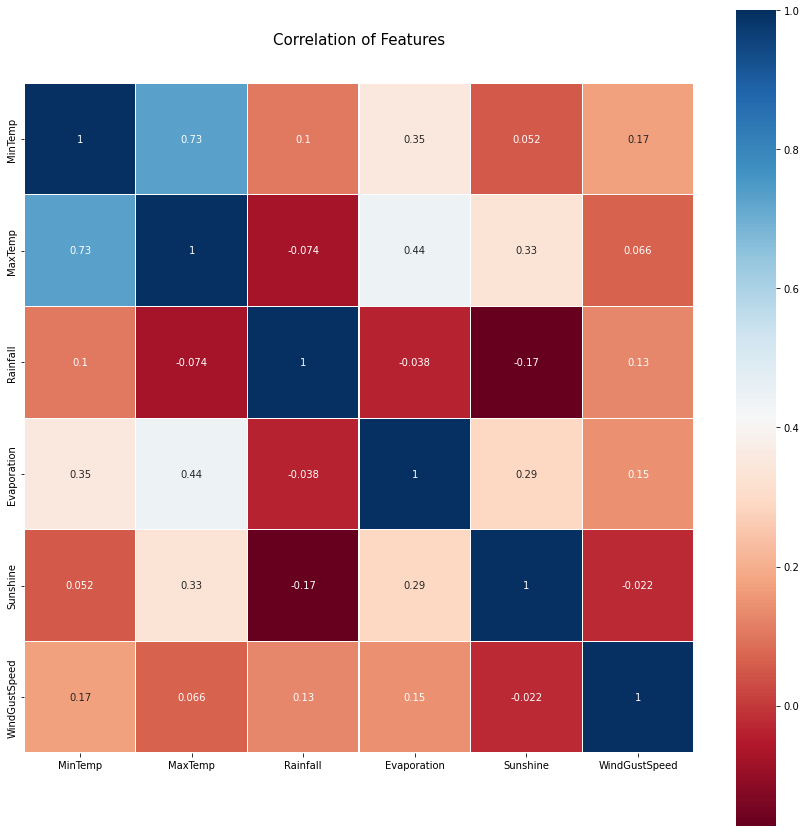

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15, 15))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(features.corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

According to the correlation matrix, `MinTemp` and `MaxTemp` are highly positively correlated thus we can replace both columns with a single one (average temp, but in the cell below I do not divide the sum because, well, what's the use, it is still linear to the true average)

In [ ]:
features['AvgTemp'] = features.apply(lambda row: (row.MinTemp + row.MaxTemp), axis=1)
del features['MaxTemp']
del features['MinTemp']

Another point I noticed is that `Rainfall` is actually really imbalanced: there are more `0.0` values then others in total! **Binarization** should be a good option here

In [ ]:
features['Rainfall'] = features['Rainfall'].map(lambda r: 1 if r > 0 else 0)

## **3. Using numerical features only 🔢**

In [ ]:
numeric_features = features.select_dtypes([np.number])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

features_train, features_test, target_train, target_test = train_test_split(numeric_features, np.ravel(target), test_size=0.25, shuffle=False)

In [ ]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [ ]:
# our model can only be fed with numpy arrays, so it is vital
# to convert them to an appropriate type to avoid errors
features_train_scaled = np.asarray(features_train_scaled)
features_test_scaled = np.asarray(features_test_scaled)

target_train = np.asarray(target_train)
target_test = np.asarray(target_test)

features_train = np.asarray(features_train)
features_test = np.asarray(features_test)

In [ ]:
print(f'ONLY NUMERIC FEATURES\n')
print(f'CUSTOM LOGISTIC REGRESSION REPORT (NO SCALING)\n')
LogIt = CustomLogItModel(iters=500, batch_size=100, h=1e-1).fit(features_train, target_train)

print(f'Classifier: {LogIt.__class__.__name__}')
target_predicted = LogIt.predict(features_train)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

ONLY NUMERIC FEATURES

CUSTOM LOGISTIC REGRESSION REPORT (NO SCALING)

Classifier: CustomLogItModel
Training accuracy: Error summary: 27624/106644 (25.9030%)
Training accuracy mean: 74.0970%
              precision    recall  f1-score   support

     No Rain       0.89      0.76      0.82     82434
        Rain       0.45      0.69      0.55     24210

    accuracy                           0.74    106644
   macro avg       0.67      0.72      0.68    106644
weighted avg       0.79      0.74      0.76    106644

Test accuracy: Error summary: 7922/35549 (22.2847%)
Test accuracy mean: 77.7153%
              precision    recall  f1-score   support

     No Rain       0.90      0.81      0.85     27882
        Rain       0.49      0.66      0.56      7667

    accuracy                           0.78     35549
   macro avg       0.69      0.73      0.71     35549
weighted avg       0.81      0.78      0.79     35549



In [ ]:
print(f'ONLY NUMERIC FEATURES\n')
print(f'CUSTOM LOGISTIC REGRESSION REPORT (WITH SCALING)\n')
LogIt = CustomLogItModel(iters=500, batch_size=100, h=1e-1).fit(features_train_scaled, target_train)

print(f'Classifier: {LogIt.__class__.__name__}')
target_predicted = LogIt.predict(features_train_scaled)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test_scaled)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

ONLY NUMERIC FEATURES

CUSTOM LOGISTIC REGRESSION REPORT (WITH SCALING)

Classifier: CustomLogItModel
Training accuracy: Error summary: 31085/106644 (29.1484%)
Training accuracy mean: 70.8516%
              precision    recall  f1-score   support

     No Rain       0.91      0.70      0.79     82434
        Rain       0.42      0.75      0.54     24210

    accuracy                           0.71    106644
   macro avg       0.66      0.72      0.66    106644
weighted avg       0.80      0.71      0.73    106644

Test accuracy: Error summary: 8606/35549 (24.2088%)
Test accuracy mean: 75.7912%
              precision    recall  f1-score   support

     No Rain       0.91      0.77      0.83     27882
        Rain       0.46      0.73      0.56      7667

    accuracy                           0.76     35549
   macro avg       0.69      0.75      0.70     35549
weighted avg       0.81      0.76      0.77     35549



In [ ]:
print(f'ONLY NUMERIC FEATURES\n')
print(f'CONSTANT SOLUTION (MEAN)\n')

target_predicted = int(target_train.mean()) * np.ones_like(target_train)
print(f'Error summary (train): { (target_predicted != target_train).sum() }/{target_train.shape[0]} ({( ((target_predicted != target_train).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Predicted {(np.mean(target_predicted == target_train)*100):.4f}% correctly')
print(classification_report(y_true=target_train,y_pred=target_predicted, target_names=['No rain', 'Rains']))

target_predicted = int(target_test.mean()) * np.ones_like(target_test)
print(f'Error summary (test): { (target_predicted != target_test).sum() }/{target_test.shape[0]} ({( ((target_predicted != target_test).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Predicted {(np.mean(target_predicted == target_test)*100):.4f}% correctly')
print(classification_report(y_true=target_test,y_pred=target_predicted, target_names=['No rain', 'Rains']))

ONLY NUMERIC FEATURES

CONSTANT SOLUTION (MEAN)

Error summary (train): 24210/106644 (22.7017%)
Predicted 77.2983% correctly
              precision    recall  f1-score   support

     No rain       0.77      1.00      0.87     82434
       Rains       0.00      0.00      0.00     24210

    accuracy                           0.77    106644
   macro avg       0.39      0.50      0.44    106644
weighted avg       0.60      0.77      0.67    106644

Error summary (test): 7667/35549 (21.5674%)
Predicted 78.4326% correctly
              precision    recall  f1-score   support

     No rain       0.78      1.00      0.88     27882
       Rains       0.00      0.00      0.00      7667

    accuracy                           0.78     35549
   macro avg       0.39      0.50      0.44     35549
weighted avg       0.62      0.78      0.69     35549



One can observe that naive classification has recall `1` for negative class and `0` for positive class (expectedly).

Peek at performance of `sklearn`'s models with numeric features

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(numeric_features, np.ravel(target), test_size=0.25, shuffle=False)

In [ ]:
print(f'ONLY NUMERIC FEATURES\n')
classifiers = [GaussianNB, BernoulliNB]
for classifier in classifiers:

  NB = classifier().fit(features_train, target_train)
  target_predicted = NB.predict(features_train)
  print(f'Classifier: {NB.__class__.__name__}')
  print('Training results')
  print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))
  print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
  print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')


  target_predicted = NB.predict(features_test)
  print('Testing results')
  print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))
  print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
  print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%\n')

ONLY NUMERIC FEATURES

Classifier: GaussianNB
Training results
              precision    recall  f1-score   support

     No Rain       0.82      0.94      0.88     82434
        Rain       0.61      0.31      0.41     24210

    accuracy                           0.80    106644
   macro avg       0.71      0.63      0.64    106644
weighted avg       0.77      0.80      0.77    106644

Training accuracy: Error summary: 21568/106644 (20.2243%)
Training accuracy mean: 79.7757%
Testing results
              precision    recall  f1-score   support

     No Rain       0.83      0.96      0.89     27882
        Rain       0.64      0.28      0.39      7667

    accuracy                           0.81     35549
   macro avg       0.74      0.62      0.64     35549
weighted avg       0.79      0.81      0.78     35549

Test accuracy: Error summary: 6696/35549 (18.8360%)
Test accuracy mean: 81.1640%

Classifier: BernoulliNB
Training results
              precision    recall  f1-score   support

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
print(f'ONLY NUMERIC FEATURES\n')
LogIt = LogisticRegression(max_iter=500).fit(features_train, target_train)

print(f'Classifier: {LogIt.__class__.__name__}')
target_predicted = LogIt.predict(features_train)
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')

target_predicted = LogIt.predict(features_test)
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')

ONLY NUMERIC FEATURES

Classifier: LogisticRegression
              precision    recall  f1-score   support

     No Rain       0.82      0.95      0.88     82434
        Rain       0.64      0.31      0.42     24210

    accuracy                           0.80    106644
   macro avg       0.73      0.63      0.65    106644
weighted avg       0.78      0.80      0.78    106644

Training accuracy: Error summary: 20957/106644 (19.6514%)
Training accuracy mean: 80.3486%
              precision    recall  f1-score   support

     No Rain       0.83      0.96      0.89     27882
        Rain       0.68      0.27      0.39      7667

    accuracy                           0.81     35549
   macro avg       0.75      0.62      0.64     35549
weighted avg       0.80      0.81      0.78     35549

Test accuracy: Error summary: 6580/35549 (18.5097%)
Test accuracy mean: 81.4903%


## **4. Preprocessing categorical features 🌐**

In [ ]:
categorical_features = features.select_dtypes(include=[object])
categorical_features

,Date,Location,WindGustDir,WindDir9am
0,2008-12-01,Albury,W,W
1,2008-12-02,Albury,WNW,NNW
2,2008-12-03,Albury,WSW,W
3,2008-12-04,Albury,NE,SE
4,2008-12-05,Albury,W,ENE
...,...,...,...,...
142188,2017-06-20,Uluru,E,ESE
142189,2017-06-21,Uluru,E,SE
142190,2017-06-22,Uluru,NNW,SE
142191,2017-06-23,Uluru,N,SE


In [ ]:
# make sure the columns were cleaned earlier
categorical_features.isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

Date           0.00% Missing Rows
Location       0.00% Missing Rows
WindGustDir    0.00% Missing Rows
WindDir9am     0.00% Missing Rows
dtype: object

In [ ]:
for col in categorical_features.columns:
  print(f'{col} value counts:')
  print(categorical_features[col].value_counts())
  print('\n')

Date value counts:
2014-06-10    49
2017-05-18    49
2016-10-07    49
2013-06-16    49
2013-06-02    49
              ..
2007-11-22     1
2007-12-28     1
2007-11-17     1
2007-12-01     1
2008-01-25     1
Name: Date, Length: 3436, dtype: int64


Location value counts:
Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3089
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albury              3011
MelbourneAirport    3009
PerthAirport        3009
Mildura             3007
Albany              3006
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cobar               2988
Cairns              2988
Wollongong          2983
GoldCoast           2980
Wagga

Handling `Date` column: drop day and year parts of iso-string, leave only month part (as most representive)

In [ ]:
categorical_features.Date = categorical_features.Date.map(lambda x: int(x.split('-')[1]))

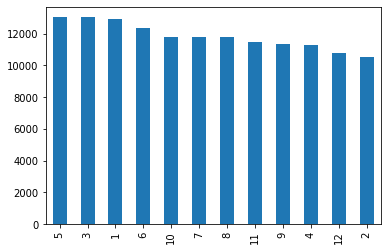

In [ ]:
categorical_features.Date.value_counts().plot.bar() # month numbers only

I found it acceptable not to process `Location` as there does not seem to be a pretty consice way of doing that. I guess that would be a nice idea to aggregate rare items into a single `Other` row and put unknown locations there, but yet do not posess enough knowlege to do that 😞

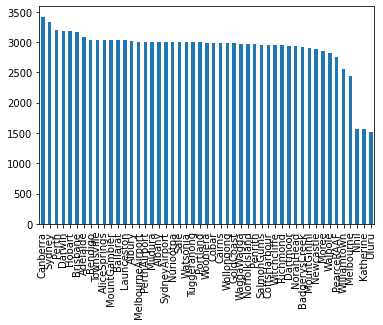

In [ ]:
categorical_features.Location.value_counts().plot.bar()

**Before reducing options:**

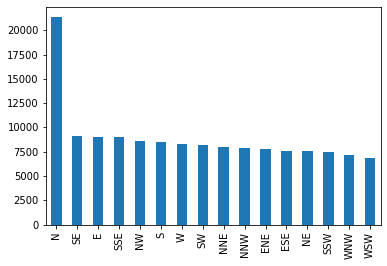

In [ ]:
categorical_features.WindDir9am.value_counts().plot.bar()

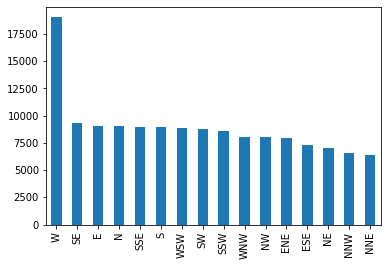

In [ ]:
categorical_features.WindGustDir.value_counts().plot.bar()

In [ ]:
categorical_features.WindGustDir = categorical_features.WindGustDir.map(lambda dir: dir[0]) # only first letter will matter
categorical_features.WindDir9am = categorical_features.WindDir9am.map(lambda dir: dir[0])

**After reducing number of wind direction categories down to four** (by the 1st letter in code)

It would be better to feed to `OneHotEncoder` later

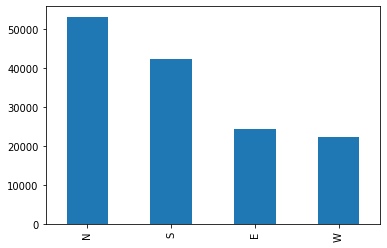

In [ ]:
categorical_features.WindDir9am.value_counts().plot.bar()

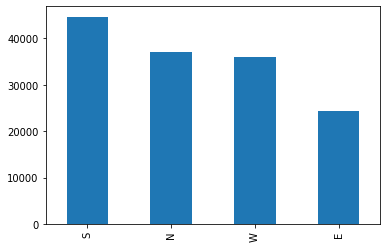

In [ ]:
categorical_features.WindGustDir.value_counts().plot.bar()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

ohe.fit_transform(categorical_features).shape

(142101, 69)

In a such way I managed to perform some kind of
**dimension reduction** along with **preserving relevant data** 
(i.e., month and primary wind direction)

Without encoding dates there would have been about **3.5e3** items after `OhE`

## **5. Combining everything and building the pipelines 🔎**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In the cells above we **filled missing values** in the dataset, extracted **numerical** and **categorical features** and **reduced** total **number of dimensions** by clustering categorical values. In this section we will create pipelines and again check classification performance of different models

### **Custom `ColumnTransformer` implementation**
In the cells below I create a custom column transformer to perform operations which were done manually before: 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [ ]:
class WeatherTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.required_cols = ('WindDir9am', 'WindGustDir',
                          'Rainfall', 'Date',
                          'Evaporation', 'Sunshine',
                          'Location', 'MinTemp', 'MaxTemp')
    pass

  def fit(self, X, y=None):
    print(f'>>> Fit called')
    return self

  def transform(self, X, y=None):
    print(f'>>> Transform called')
    
    # check features presence
    for col in self.required_cols:
      if col not in X.columns: raise ValueError(f'Check your features columns: {col} missing!')
    
    X_ = X.copy()

    # fill missing values (just in case)
    for col in X_.select_dtypes(include=np.number):
      X_[col].replace(np.nan, X_[col].mean(), inplace=True)

    for col in X_.select_dtypes(include=object):
      X_[col].replace(np.nan, X_[col].mode().values[0], inplace=True)
    
    # do the transformations
    if 'AvgTemp' not in X.columns:
      X_['AvgTemp'] = X_.apply(lambda row: (row.MinTemp + row.MaxTemp), axis=1)
      del X_['MaxTemp']
      del X_['MinTemp']
    
    X_.WindDir9am = X_.WindDir9am.map(lambda dir: dir[0])
    X_.WindGustDir = X_.WindGustDir.map(lambda dir: dir[0])
    X_.Date = X_.Date.map(lambda x: int(x.split('-')[1]))
    X_.Rainfall = X_.Rainfall.map(lambda r: '1' if r > 0 else '0')
    
    return X_

In [ ]:
wt = WeatherTransformer()
features_transformed = wt.fit_transform(features, target)
# that's how the features look like 
# after transformations encapsulated within `WeatherTransformer`
numeric_features_names = list(features_transformed.select_dtypes(include=np.number))
categorical_features_names = list(features_transformed.select_dtypes(include=object))
features_transformed

>>> Fit called
>>> Transform called


,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,AvgTemp
0,12,Albury,1,5.469824,7.624853,W,44.0,W,36.3
1,12,Albury,0,5.469824,7.624853,W,44.0,N,32.5
2,12,Albury,0,5.469824,7.624853,W,46.0,W,38.6
3,12,Albury,0,5.469824,7.624853,N,24.0,S,37.2
4,12,Albury,1,5.469824,7.624853,W,41.0,E,49.8
...,...,...,...,...,...,...,...,...,...
142188,6,Uluru,0,5.469824,7.624853,E,31.0,E,25.3
142189,6,Uluru,0,5.469824,7.624853,E,31.0,S,26.2
142190,6,Uluru,0,5.469824,7.624853,N,22.0,S,28.9
142191,6,Uluru,0,5.469824,7.624853,N,37.0,S,32.3


In [ ]:
# that's how the features look like after ohe & scaling
ct = ColumnTransformer(
    [('scaler', StandardScaler(), numeric_features_names),
     ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features_names)])
ct.fit_transform(features_transformed)

array([[ 1.63359933e+00,  1.31890395e+00,  2.52233565e-15, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.63359933e+00, -7.58205327e-01,  2.52233565e-15, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.63359933e+00, -7.58205327e-01,  2.52233565e-15, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [-1.17452748e-01, -7.58205327e-01,  2.52233565e-15, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.17452748e-01, -7.58205327e-01,  2.52233565e-15, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.17452748e-01, -7.58205327e-01,  2.52233565e-15, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

### **Pipeline with `OneHotEncoder`**

In [ ]:
DataPreprocessingPipeline = Pipeline(
    steps=[
           ('weather preprocessing', WeatherTransformer(),),
           ('ohe & scaling', ColumnTransformer([
                                                ('scaler', StandardScaler(), numeric_features_names),
                                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features_names)
                                                ])),
    ])

features_encoded = DataPreprocessingPipeline.fit_transform(features)

>>> Fit called
>>> Transform called


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features_encoded, np.ravel(target), test_size=0.25, shuffle=False)

In [ ]:
print(f'TRANSFORMATIONS: OHE & STD SCALING')
classifiers = [GaussianNB, BernoulliNB]
for classifier in classifiers:

  NB = classifier().fit(features_train, target_train)
  target_predicted = NB.predict(features_train)
  print(f'Classifier: {NB.__class__.__name__}')
  print('Training results')
  print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
  print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
  print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))


  target_predicted = NB.predict(features_test)
  print('Testing results')
  print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
  print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%\n')
  print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: OHE & STD SCALING
Classifier: GaussianNB
Training results
Training accuracy: Error summary: 44348/106575 (41.6120%)
Training accuracy mean: 58.3880%
              precision    recall  f1-score   support

     No Rain       0.84      0.57      0.68     82389
        Rain       0.30      0.64      0.41     24186

    accuracy                           0.58    106575
   macro avg       0.57      0.60      0.54    106575
weighted avg       0.72      0.58      0.62    106575

Testing results
Test accuracy: Error summary: 8401/35526 (23.6475%)
Test accuracy mean: 76.3525%

              precision    recall  f1-score   support

     No Rain       0.89      0.80      0.84     27868
        Rain       0.47      0.65      0.54      7658

    accuracy                           0.76     35526
   macro avg       0.68      0.72      0.69     35526
weighted avg       0.80      0.76      0.78     35526

Classifier: BernoulliNB
Training results
Training accuracy: Error summary: 23712/1

In [ ]:
print(f'TRANSFORMATIONS: OHE & STD SCALING')
KNN = KNeighborsClassifier(n_neighbors=11).fit(features_train, target_train)

print(f'Classifier: {KNN.__class__.__name__}')
target_predicted = KNN.predict(features_train)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))


target_predicted = KNN.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: OHE & STD SCALING
Classifier: KNeighborsClassifier
Training accuracy: Error summary: 17682/106575 (16.5911%)
Training accuracy mean: 83.4089%
              precision    recall  f1-score   support

     No Rain       0.85      0.95      0.90     82389
        Rain       0.72      0.44      0.55     24186

    accuracy                           0.83    106575
   macro avg       0.79      0.70      0.72    106575
weighted avg       0.82      0.83      0.82    106575

Test accuracy: Error summary: 7022/35526 (19.7658%)
Test accuracy mean: 80.2342%
              precision    recall  f1-score   support

     No Rain       0.83      0.94      0.88     27868
        Rain       0.58      0.32      0.41      7658

    accuracy                           0.80     35526
   macro avg       0.70      0.63      0.65     35526
weighted avg       0.78      0.80      0.78     35526



In [ ]:
print(f'TRANSFORMATIONS: OHE & STD SCALING')
print(f'CUSTOM LOGISTIC REGRESSION\n')
LogIt = CustomLogItModel(iters=500, batch_size=100, h=1e-1).fit(features_train, target_train)

print(f'Classifier: {LogIt.__class__.__name__}')
target_predicted = LogIt.predict(features_train)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: OHE & STD SCALING
CUSTOM LOGISTIC REGRESSION

Classifier: CustomLogItModel
Training accuracy: Error summary: 21613/106644 (20.2665%)
Training accuracy mean: 79.7335%
              precision    recall  f1-score   support

     No Rain       0.82      0.94      0.88     82434
        Rain       0.60      0.31      0.41     24210

    accuracy                           0.80    106644
   macro avg       0.71      0.63      0.65    106644
weighted avg       0.77      0.80      0.77    106644

Test accuracy: Error summary: 6820/35549 (19.1848%)
Test accuracy mean: 80.8152%
              precision    recall  f1-score   support

     No Rain       0.83      0.95      0.89     27882
        Rain       0.61      0.30      0.40      7667

    accuracy                           0.81     35549
   macro avg       0.72      0.62      0.64     35549
weighted avg       0.78      0.81      0.78     35549



In [ ]:
print(f'TRANSFORMATIONS: OHE & STD SCALING')
LogIt = LogisticRegression(max_iter=500).fit(features_train, target_train)

target_predicted = LogIt.predict(features_train)

print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( np.mean(target_predicted != target_train)*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( np.mean(target_predicted != target_test)*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: OHE & STD SCALING
Training accuracy: Error summary: 20920/106575 (19.6294%)
Training accuracy mean: 80.3706%
              precision    recall  f1-score   support

     No Rain       0.82      0.95      0.88     82389
        Rain       0.64      0.31      0.42     24186

    accuracy                           0.80    106575
   macro avg       0.73      0.63      0.65    106575
weighted avg       0.78      0.80      0.78    106575

Test accuracy: Error summary: 6527/35526 (18.3725%)
Test accuracy mean: 81.6275%
              precision    recall  f1-score   support

     No Rain       0.83      0.96      0.89     27868
        Rain       0.67      0.29      0.41      7658

    accuracy                           0.82     35526
   macro avg       0.75      0.63      0.65     35526
weighted avg       0.80      0.82      0.79     35526



The quality metrics actually could be better...

Accuracy did not increase drastically, however, in comparison with purely numeric prediction... f1-score is 1e-2 higher, the `Rain` recall increased a little bit. Well, that is truly funny

Not to mention that I omitted binarization that last time with numeric prediction. OK, at least it did not decrease

This one took half an hour to compute, for heaven's sake, **DO NOT RERUN** this cell

I consider time consumption that big to be correlated to the number of dimensions. Later I utulized `OrdinalEncoder` and it yielded the result much faster

In [ ]:
k_values = range(1, 10)
scores_train = []
scores_test = []

for k_value in k_values:
  classifier = KNeighborsClassifier(n_neighbors=k_value).fit(features_train, target_train)

  k_prediction_train = classifier.predict(features_train)
  k_prediction_test = classifier.predict(features_test)
  
  scores_test.append((np.mean(k_prediction_test == target_test)))
  scores_train.append((np.mean(k_prediction_train == target_train)))

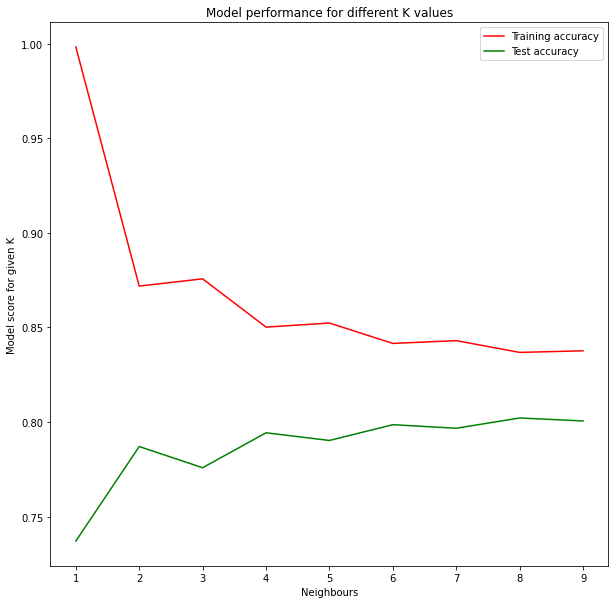

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(k_values, scores_train, color='red', label='Training accuracy')
plt.plot(k_values, scores_test, color='green', label='Test accuracy')
plt.xticks(range(1,10))
plt.xlabel('Neighbours')
plt.ylabel('Model score for given K')
plt.title('Model performance for different K values')
plt.legend(loc='best')
plt.show()

### **Pipeline with `OrdinalEncoder`**

In [ ]:
DataPreprocessingPipeline = Pipeline(
    steps=[
           ('weather preprocessing', WeatherTransformer(),),
           ('ordinal & scaling', ColumnTransformer([
                                                ('scaler', StandardScaler(), numeric_features_names),
                                                ('ordinal', OrdinalEncoder(), categorical_features_names)
                                                ])),
    ])

features_encoded = DataPreprocessingPipeline.fit_transform(features)

>>> Fit called
>>> Transform called


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features_encoded, np.ravel(target), test_size=0.25, shuffle=False)

In [ ]:
k_values = range(1, 20)
scores_train = []
scores_test = []

for k_value in k_values:
  classifier = KNeighborsClassifier(n_neighbors=k_value).fit(features_train, target_train)
  print(f'Now training KNN for k={k_value}')
  k_prediction_train = classifier.predict(features_train)
  k_prediction_test = classifier.predict(features_test)
  
  scores_test.append((np.mean(k_prediction_test == target_test)))
  scores_train.append((np.mean(k_prediction_train == target_train)))

Now training KNN for k=1
Now training KNN for k=2
Now training KNN for k=3
Now training KNN for k=4
Now training KNN for k=5
Now training KNN for k=6
Now training KNN for k=7
Now training KNN for k=8
Now training KNN for k=9
Now training KNN for k=10
Now training KNN for k=11
Now training KNN for k=12
Now training KNN for k=13
Now training KNN for k=14
Now training KNN for k=15
Now training KNN for k=16
Now training KNN for k=17
Now training KNN for k=18
Now training KNN for k=19


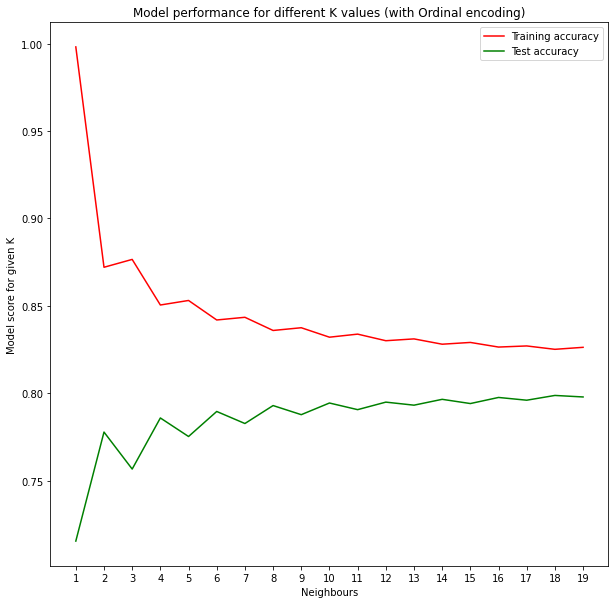

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(k_values, scores_train, color='red', label='Training accuracy')
plt.plot(k_values, scores_test, color='green', label='Test accuracy')
plt.xticks(range(1,20))
plt.xlabel('Neighbours')
plt.ylabel('Model score for given K')
plt.title('Model performance for different K values (with Ordinal encoding)')
plt.legend(loc='best')
plt.show()

One can eye that the asymptotic accuracy for both `OHE` and `OrdinalEncoder` is about 80%. It should also be noted that pure accuracy isn't the best metric in this particular case as (once again) the classes are imbalanced. Because of that one may think of some kind of over-/undersampling, but I am running out of time 😞

I also have a question: why is train accuracy decreasing as test accuracy increases?

Now we will have a look at the classification report for the models:

In [ ]:
print(f'TRANSFORMATIONS: ORDINAL & STD SCALING')
classifiers = [GaussianNB, BernoulliNB]
for classifier in classifiers:

  NB = classifier().fit(features_train, target_train)
  target_predicted = NB.predict(features_train)
  print(f'Classifier: {NB.__class__.__name__}')
  print('Training results')
  print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
  print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
  print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))


  target_predicted = NB.predict(features_test)
  print('Testing results')
  print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
  print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%\n')
  print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: ORDINAL & STD SCALING
Classifier: GaussianNB
Training results
Training accuracy: Error summary: 22643/106575 (21.2461%)
Training accuracy mean: 78.7539%
              precision    recall  f1-score   support

     No Rain       0.83      0.91      0.87     82389
        Rain       0.55      0.39      0.45     24186

    accuracy                           0.79    106575
   macro avg       0.69      0.65      0.66    106575
weighted avg       0.77      0.79      0.77    106575

Testing results
Test accuracy: Error summary: 6635/35526 (18.6765%)
Test accuracy mean: 81.3235%

              precision    recall  f1-score   support

     No Rain       0.84      0.94      0.89     27868
        Rain       0.62      0.36      0.45      7658

    accuracy                           0.81     35526
   macro avg       0.73      0.65      0.67     35526
weighted avg       0.79      0.81      0.79     35526

Classifier: BernoulliNB
Training results
Training accuracy: Error summary: 240

In [ ]:
print(f'TRANSFORMATIONS: ORDINAL & STD SCALING')
KNN = KNeighborsClassifier(n_neighbors=11).fit(features_train, target_train)

print(f'Classifier: {KNN.__class__.__name__}')
target_predicted = KNN.predict(features_train)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))


target_predicted = KNN.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: ORDINAL & STD SCALING
Classifier: KNeighborsClassifier
Training accuracy: Error summary: 17712/106575 (16.6193%)
Training accuracy mean: 83.3807%
              precision    recall  f1-score   support

     No Rain       0.85      0.95      0.90     82389
        Rain       0.72      0.44      0.55     24186

    accuracy                           0.83    106575
   macro avg       0.79      0.69      0.72    106575
weighted avg       0.82      0.83      0.82    106575

Test accuracy: Error summary: 7440/35526 (20.9424%)
Test accuracy mean: 79.0576%
              precision    recall  f1-score   support

     No Rain       0.82      0.94      0.88     27868
        Rain       0.53      0.25      0.34      7658

    accuracy                           0.79     35526
   macro avg       0.68      0.59      0.61     35526
weighted avg       0.76      0.79      0.76     35526



In [ ]:
print(f'TRANSFORMATIONS: ORDINAL & STD SCALING')
LogIt = LogisticRegression(max_iter=500).fit(features_train, target_train)

target_predicted = LogIt.predict(features_train)

print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: ORDINAL & STD SCALING
Training accuracy: Error summary: 21300/106575 (19.9859%)
Training accuracy mean: 80.0141%
              precision    recall  f1-score   support

     No Rain       0.82      0.95      0.88     82389
        Rain       0.63      0.29      0.40     24186

    accuracy                           0.80    106575
   macro avg       0.72      0.62      0.64    106575
weighted avg       0.78      0.80      0.77    106575

Test accuracy: Error summary: 6675/35526 (18.7891%)
Test accuracy mean: 81.2109%
              precision    recall  f1-score   support

     No Rain       0.83      0.96      0.89     27868
        Rain       0.66      0.27      0.38      7658

    accuracy                           0.81     35526
   macro avg       0.74      0.62      0.64     35526
weighted avg       0.79      0.81      0.78     35526



In [ ]:
print(f'TRANSFORMATIONS: ORDINAL & STD SCALING')
print(f'CUSTOM LOGISTIC REGRESSION\n')
LogIt = CustomLogItModel(iters=500, batch_size=100, h=1e-1).fit(features_train, target_train)

print(f'Classifier: {LogIt.__class__.__name__}')
target_predicted = LogIt.predict(features_train)
print(f'Training accuracy: Error summary: { (target_train != target_predicted).sum() }/{target_train.shape[0]} ({( ((target_train != target_predicted).sum()/target_train.shape[0])*100 ):.4f}%)')
print(f'Training accuracy mean: {(np.mean(target_predicted == target_train)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_train, target_names=['No Rain', 'Rain']))

target_predicted = LogIt.predict(features_test)
print(f'Test accuracy: Error summary: { (target_test != target_predicted).sum() }/{target_test.shape[0]} ({( ((target_test != target_predicted).sum()/target_test.shape[0])*100 ):.4f}%)')
print(f'Test accuracy mean: {(np.mean(target_predicted == target_test)*100):.4f}%')
print(classification_report(y_pred=target_predicted, y_true=target_test, target_names=['No Rain', 'Rain']))

TRANSFORMATIONS: ORDINAL & STD SCALING
CUSTOM LOGISTIC REGRESSION

Classifier: CustomLogItModel
Training accuracy: Error summary: 22661/106644 (21.2492%)
Training accuracy mean: 78.7508%
              precision    recall  f1-score   support

     No Rain       0.83      0.90      0.87     82434
        Rain       0.54      0.39      0.45     24210

    accuracy                           0.79    106644
   macro avg       0.69      0.65      0.66    106644
weighted avg       0.77      0.79      0.77    106644

Test accuracy: Error summary: 7278/35549 (20.4731%)
Test accuracy mean: 79.5269%
              precision    recall  f1-score   support

     No Rain       0.84      0.92      0.88     27882
        Rain       0.54      0.35      0.43      7667

    accuracy                           0.80     35549
   macro avg       0.69      0.64      0.65     35549
weighted avg       0.77      0.80      0.78     35549



## **6. Final thoughts and conclusion 📋**


After trying different approaches (using solely numeric features, or numeric along with categorical encoded via `OrdinalEncoder` and `OneHotEncoder`) 
classification reports were **slightly controversal**: as stated several times earlier, the classes are quite imbalanced (the ratio is about 1:4) thus vanilla accuracy metric *will not* be the most reliable. 

Though I am still a bit cunfused about confusion matrix, I was looking for highest **recall** for `Rains` class and **f1-score** for both classes. Among all runs, the **best recall** for `Rains` was achieved by our own implementation of logistic regression with numeric features and reached `0.76` on train and `0.73` on test while **f1-score** reached `0.54` and `0.56` respectievely. `GaussianNB` with `OhE` has simularly high recall score for both train and test while `BernoulliNB` has great test recall of `0.72` on test and surprisingly low recall (`0.32`) on train.

 One can observe that with `sklearn` models gain **lesser recall** values and **greater precision**. I believe that it **is better to have less false negatives than less false positives in this particular case** (sudden shower is less pleasing than lack of promised one). In this case the most performant model is our custom one trained using only numeric features! (at least, that is what I managed to get, there *should* be better options)

If we search best precision, we should choose `LogisticRegression` with `OhE` and scaling, it produces precision of `0.64` on train and `0.67` on test. Its metrics are actually very simular to our implementation, but the precision is higher. 

I should also mention than `KNN`-classifier tends to overfit by outperforming other models on train (recall of `0.44` and `0.74` precision) but having really bad scores (recall of `0.58` and `0.32` precision) on test for k=11. I avoided using greater k as with many dimensions time consumption was huge.

Another important point is that we use unshuffled data. Shuffling may result into better metrics on general case. One could also utilize cross-validation, but I used a vanilla case with train and test.

## **TODO: 🐜**






+ ~~resolve column name conflicts~~
+ ~~implement `WeatherTransform` transformer to handle dimension reduction for `OneHotEncoder` later~~
+ ~~implement `Pipeline`~~
+ ~~implement generic pipeline for all models~~ (created single pipeline wrapping all data transformations)
+ ~~check classification report for all features~~
+ ~~try using `OrdinalEncoder` for categorical features and compare its performance~~ (resulted in apparent decrease of recall and f1-score for all models)
+ try using decision tree as it should perform really well with imbalanced classes
+ try using cross-validation, it may increase the metrics